# Figure 1
- schematic
- spectrogram for NSD and SD
- lfp snapshots for sleep classification
- percentage or something for sleep fraction


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from neuropy import plotting
from neuropy.utils import signal_process
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import subjects
import pandas as pd

sd_sessions = subjects.sd.allsess[2:-1]
nsd_sessions = subjects.nsd.ratNday2 + subjects.nsd.ratSday2 + subjects.nsd.ratUday2
print(sd_sessions)
print(nsd_sessions)


# Number of Neruons

In [ ]:
n_neurons_sd = np.sum([_.neurons.get_neuron_type("pyr").n_neurons for _ in sd_sessions])
n_neurons_nsd = np.sum(
    [_.neurons.get_neuron_type("pyr").n_neurons for _ in nsd_sessions]
)
n_neurons = [n_neurons_sd, n_neurons_nsd]
n_animals = [len(sd_sessions), len(nsd_sessions)]


# Calculating spectrogram

In [8]:
spects = []
for sess in [sd_sessions[1], nsd_sessions[1]]:
    t_start, t_stop = sess.paradigm["post"].flatten()
    signal = sess.eegfile.get_signal(113, t_start=t_start, t_stop=t_stop)
    spects.append(
        signal_process.TimeFrequency(
            signal, freqs=np.arange(1, 20, 0.5), window=5 * 60, overlap=60
        )
    )


# Sleep fraction during 5 hours following MAZE

In [10]:
sleep_df = pd.DataFrame()
for grp_ind, sessions in enumerate([sd_sessions, nsd_sessions]):
    for sub, sess in enumerate(sessions):
        maze = sess.paradigm["maze"].flatten()
        period = [maze[1], maze[1] + 5 * 3600]
        prop = sess.brainstates.get_proportion_by_label(period[0], period[1])
        if "nan" in prop.keys():
            del prop["nan"]

        if grp_ind == 0:
            grp = "sd"

        if grp_ind == 1:
            grp = "nsd"

        sleep_df = sleep_df.append(
            pd.DataFrame(
                {
                    "prop": list(prop.values()),
                    "state": list(prop.keys()),
                    "grp": grp,
                }
            ),
            ignore_index=True,
        )


# Firing rate
- normalized firing rate or mean firing rate across population?
- across all states and also in individual states

## Normalized firing (mean across session)

In [12]:
frate_df = pd.DataFrame()
for neuron_type in ["pyr", "inter"]:
    for sessions, grp in zip([sd_sessions, nsd_sessions], ["sd", "nsd"]):
        for sub, sess in enumerate(sessions):
            pre = sess.paradigm["pre"].flatten()
            maze = sess.paradigm["maze"].flatten()
            post = sess.paradigm["post"].flatten()
            rec_duration = sess.eegfile.duration
            neurons = sess.neurons.get_neuron_type(neuron_type)

            bin_size = 60
            bin_spk_pre = neurons.time_slice(pre[0], maze[1]).get_binned_spiketrains(
                bin_size=bin_size
            )
            bin_spk_post = neurons.time_slice(
                maze[1], maze[1] + 9 * 3600
            ).get_binned_spiketrains(bin_size=bin_size)

            bins = np.arange(-bin_spk_pre.n_bins, bin_spk_post.n_bins) * (60 / 3600)
            spkcounts = np.hstack((bin_spk_pre.spike_counts, bin_spk_post.spike_counts))
            spkcounts = gaussian_filter1d(spkcounts, sigma=5, axis=-1)
            frate = spkcounts / bin_size
            frate_zscore = stats.zscore(frate, axis=1)
            mean_frate = np.mean(frate_zscore, axis=0)
            # mean_frate = gaussian_filter1d(mean_frate,sigma=2)
            frate_df = frate_df.append(
                pd.DataFrame(
                    {
                        "bins": bins,
                        "frate": mean_frate,
                        "neuron_type": neuron_type,
                        "sub": sub,
                        "grp": grp,
                    }
                ),
                ignore_index=True,
            )


## Normalized firing rate pooled across cells

In [13]:
from neuropy.analyses import neurons_stability

frate_df_pooled = pd.DataFrame()
for neuron_type in ["pyr", "inter"]:
    for sessions, grp in zip([sd_sessions, nsd_sessions], ["sd", "nsd"]):
        for sub, sess in enumerate(sessions):
            pre = sess.paradigm["pre"].flatten()
            maze = sess.paradigm["maze"].flatten()
            post = sess.paradigm["post"].flatten()
            rec_duration = sess.eegfile.duration
            neurons = sess.neurons.get_neuron_type(neuron_type)
            neurons_stable_bool = neurons_stability.firing_rate_stability(
                neurons=neurons, window=4 * 3600
            )
            neurons = neurons[np.where(neurons_stable_bool == 1)[0]]

            bin_size = 60
            bin_spk_pre = neurons.time_slice(pre[0], maze[1]).get_binned_spiketrains(
                bin_size=bin_size
            )
            bin_spk_post = neurons.time_slice(
                maze[1], maze[1] + 9 * 3600
            ).get_binned_spiketrains(bin_size=bin_size)

            bins = np.arange(-bin_spk_pre.n_bins, bin_spk_post.n_bins) * (60 / 3600)
            spkcounts = np.hstack((bin_spk_pre.spike_counts, bin_spk_post.spike_counts))
            spkcounts = gaussian_filter1d(spkcounts, sigma=5, axis=-1)
            frate = spkcounts / bin_size
            frate_zscore = stats.zscore(frate, axis=1)

            frate_flat = frate_zscore.flatten()
            bin_flat = np.tile(bins, (neurons.n_neurons, 1)).flatten()

            # mean_frate = np.mean(frate_zscore, axis=0)
            # mean_frate = gaussian_filter1d(mean_frate,sigma=2)

            frate_df_pooled = frate_df_pooled.append(
                pd.DataFrame(
                    {
                        "bins": bin_flat,
                        "frate": frate_flat,
                        "neuron_type": neuron_type,
                        "sub": sub,
                        "grp": grp,
                    }
                ),
                ignore_index=True,
            )


## Change in firing rate from first to last hour

In [15]:
from neuropy.analyses import neurons_stability

frate_1v5_df = pd.DataFrame()
for neuron_type in ["pyr", "inter"]:
    for sessions, grp in zip([sd_sessions, nsd_sessions], ["sd", "nsd"]):
        for sub, sess in enumerate(sessions):
            post = sess.paradigm["post"].flatten()
            rec_duration = sess.eegfile.duration
            neurons = sess.neurons.get_neuron_type(neuron_type)
            neurons_stable_bool = neurons_stability.firing_rate_stability(
                neurons=neurons.time_slice(post[0], post[0] + 5 * 3600)
            )
            neurons = neurons[np.where(neurons_stable_bool == 1)[0]]

            f_rate = []
            for i, (t_start, hour) in enumerate(
                zip([post[0], post[0] + 3 * 3600], ["0-2", "3-5"])
            ):
                f_rate.append(
                    neurons.time_slice(t_start, t_start + 2 * 3600).firing_rate
                )

            f_rate = np.asarray(f_rate).T

            frate_1v5_df = frate_1v5_df.append(
                pd.DataFrame(
                    {
                        # "hour": hour,
                        "frate": (np.diff(f_rate, axis=1) * 100)[:, 0] / f_rate[:, 0],
                        "sub": sub,
                        "grp": grp,
                        "neuron_type": neuron_type,
                    }
                ),
                ignore_index=True,
            )


/home/bapung/Documents/Codes/NeuroPy/neuropy/analyses/neurons_stability.py:26: RuntimeWarning: invalid value encountered in true_divide
  frate_ratio = window_frate / frate


## Do cells which increased their firing rate the most from PRE to MAZE are the ones increasing their firing rate during SD

In [16]:
from neuropy.analyses import neurons_stability

frate_maze_vs_5_df = pd.DataFrame()
for neuron_type in ["pyr", "inter"]:
    for sessions, grp in zip([sd_sessions, nsd_sessions], ["sd", "nsd"]):
        for sub, sess in enumerate(sessions):
            pre = sess.paradigm["pre"].flatten()
            maze = sess.paradigm["maze"].flatten()
            if maze.size == 0:
                maze = sess.paradigm["maze1"].flatten()
            post = sess.paradigm["post"].flatten()
            rec_duration = sess.eegfile.duration
            neurons = sess.neurons.get_neuron_type(neuron_type)
            neurons_stable_bool = neurons_stability.firing_rate_stability(
                neurons=neurons, window=4 * 3600
            )
            neurons = neurons[np.where(neurons_stable_bool == 1)[0]]

            f_rate = []
            for i, (t_start, t_end) in enumerate(
                zip(
                    [pre[0], maze[0], post[0], post[0] + 4 * 3600],
                    [pre[1], maze[1], post[0] + 3600, post[0] + 5 * 3600],
                )
            ):
                f_rate.append(neurons.time_slice(t_start, t_end).firing_rate)

            f_rate = np.asarray(f_rate).T
            diff_pre_maze = np.diff(f_rate[:, :2], axis=1)[:, 0] / f_rate[:, 0]
            diff_post = np.diff(f_rate[:, 2:], axis=1)[:, 0] / f_rate[:, 2]

            frate_maze_vs_5_df = frate_maze_vs_5_df.append(
                pd.DataFrame(
                    {
                        # "hour": hour,
                        "pre_maze": diff_pre_maze * 100,
                        "post": diff_post * 100,
                        # "frate": f_rate,  # np.diff(f_rate) * 100 / f_rate[0],
                        "sub": sub,
                        "grp": grp,
                        "neuron_type": neuron_type,
                    }
                ),
                ignore_index=True,
            )


/tmp/ipykernel_1590041/2787705950.py:29: RuntimeWarning: invalid value encountered in true_divide
  diff_pre_maze = np.diff(f_rate[:,:2],axis=1)[:,0]/f_rate[:,0]


## Dividing Neurons into quantiles based on their increase in firing rate from PRE to MAZE and observe how these quantiles change during SD

In [17]:
from neuropy.analyses import neurons_stability

nQuantiles = 5
bin_size = 15 * 60

frate_maze_vs_sd = pd.DataFrame()
for neuron_type in ["pyr"]:
    for sessions, grp in zip([sd_sessions, nsd_sessions], ["sd", "nsd"]):
        pre_to_maze = []
        post_frate = []
        for sub, sess in enumerate(sessions):
            pre = sess.paradigm["pre"].flatten()
            maze = sess.paradigm["maze"].flatten()
            if maze.size == 0:
                maze = sess.paradigm["maze1"].flatten()
            post = sess.paradigm["post"].flatten()
            rec_duration = sess.eegfile.duration
            neurons = sess.neurons.get_neuron_type(neuron_type)
            neurons_stable_bool = neurons_stability.firing_rate_stability(
                neurons=neurons, window=4 * 3600
            )
            neurons = neurons[np.where(neurons_stable_bool == 1)[0]]

            f_rate = []
            for i, (t_start, t_end) in enumerate(
                zip([pre[0], maze[0]], [pre[1], maze[1]])
            ):
                f_rate.append(neurons.time_slice(t_start, t_end).firing_rate)

            f_rate = np.asarray(f_rate).T
            pre_to_maze.append(np.diff(f_rate, axis=1)[:, 0] / f_rate[:, 0])

            binspk = neurons.time_slice(
                post[0], post[0] + 5 * 3600
            ).get_binned_spiketrains(bin_size=bin_size)

            post_frate.append(binspk.spike_counts / bin_size)

        pre_to_maze = np.concatenate(pre_to_maze)
        post_frate = np.vstack(post_frate)

        quantiles = pd.qcut(pre_to_maze, q=nQuantiles, labels=False)
        quant_mean_frate = [
            np.nanmean(post_frate[quantiles == q, :], axis=0) for q in range(nQuantiles)
        ]
        quant_mean_frate = np.asarray(quant_mean_frate)
        first_bin = quant_mean_frate[:, 0]
        quant_mean_frate = quant_mean_frate / first_bin[:, np.newaxis]

        df = pd.DataFrame(
            quant_mean_frate, columns=np.arange(quant_mean_frate.shape[1])
        )
        df["grp"] = grp
        df["quantiles"] = np.arange(nQuantiles)
        frate_maze_vs_sd = frate_maze_vs_sd.append(df)

frate_maze_vs_sd = pd.melt(
    frate_maze_vs_sd,
    id_vars=["grp", "quantiles"],
    value_vars=np.arange(20),
    var_name=["bins"],
    value_name="frate",
    ignore_index=True,
)

frate_maze_vs_sd["bins"] = frate_maze_vs_sd["bins"] * (bin_size / 3600)


/tmp/ipykernel_1590041/3309065960.py:31: RuntimeWarning: invalid value encountered in true_divide
  pre_to_maze.append(np.diff(f_rate, axis=1)[:, 0] / f_rate[:, 0])


# Plotting

/home/bapung/miniconda3/envs/data_analysis/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 12.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/bapung/miniconda3/envs/data_analysis/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 41.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


(0.0, 1.0, 0.0, 1.0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
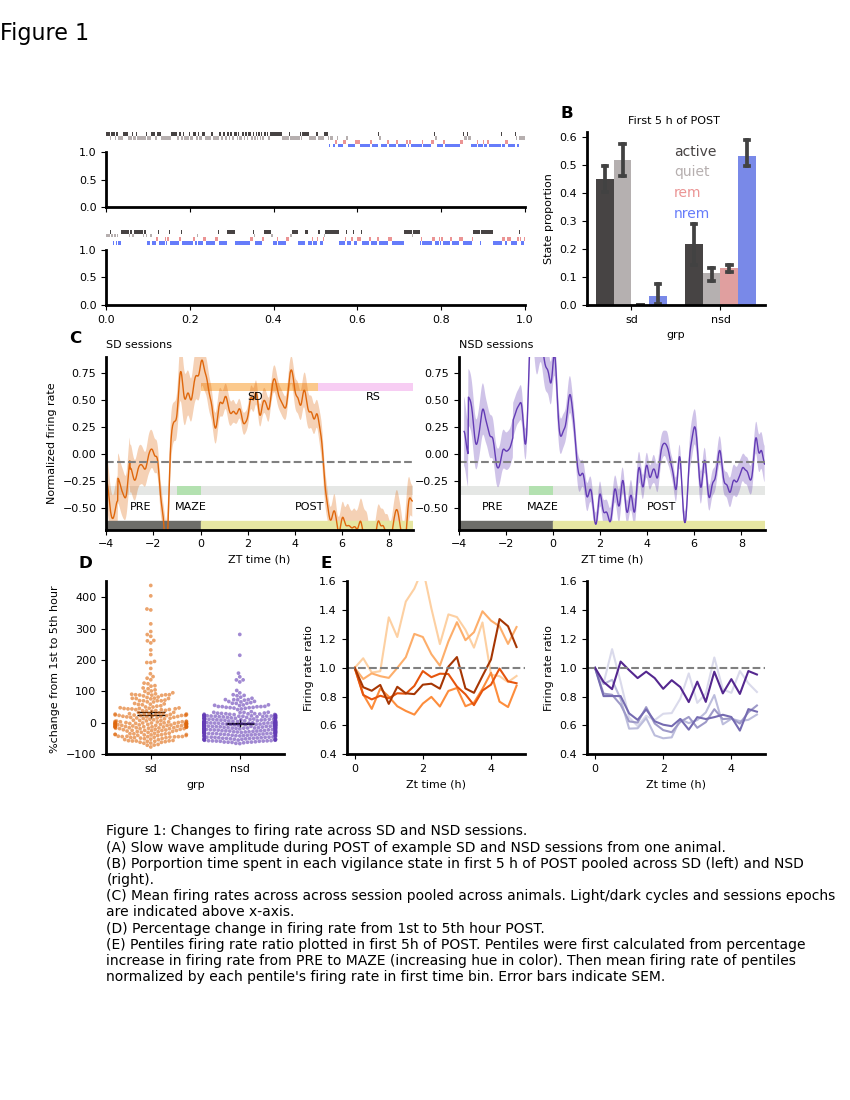

In [22]:
%matplotlib widget
from palettable.colorbrewer.sequential import Oranges_6, Purples_6

figure = plotting.Fig()
fig, gs = figure.draw(num=1, grid=(4, 3), hspace=0.3, wspace=0.35)
fig.suptitle("Figure 1", x=0, ha="left", fontsize=16)

# ------ panel a --------
gs_spect = figure.subplot2grid(gs[0, :2], grid=(2, 1))
brainstates = [
    sess.brainstates.time_slice(
        sess.paradigm["post"].flatten()[0], sess.paradigm["post"].flatten()[1]
    )
    for sess in [sd_sessions[1], nsd_sessions[1]]
]
t_starts = [
    sess.paradigm["post"].flatten()[0] for sess in [sd_sessions[1], nsd_sessions[1]]
]
# ....spectrogram.......
for i, spect in enumerate(spects):
    gs_swa = figure.subplot2grid(gs_spect[i], grid=(4, 1))
    ax_theta = plt.subplot(gs_swa[1:])
    # plotting.plot_spectrogram(spect.sxx,spect.time,spect.freq,ax=ax_spect,cmap='plasma',sigma=1,freq_lim=(0,20))
    # ax_spect.set_ylabel('Frequency (Hz)')
    # ax_theta = ax_spect.twinx()
    # spect_val = spect.get_band_power(2,6)
    # ax_theta.plot(
    #     (spect.time - spect.time[0]) / 3600,
    #     spect.delta / np.ptp(spect.delta),
    #     color="k",
    #     lw=1,
    # )
    # # ax_theta.plot(spect.time,stats.zscore(spect.theta_deltaplus_ratio),color='r',lw=1)
    # # ax_theta.set_ylim(top=10)
    # ax_theta.set_xlim(left=0, right=(spect.time[-1] - spect.time[0]) / 3600)
    # ax_theta.set_ylabel("SWA")
    # ax_theta.set_xlabel("Zt time (h)")

    ax_hypno = plt.subplot(gs_swa[0])
    plotting.plot_hypnogram(brainstates[i], ax=ax_hypno)

    if i == 0:
        ax_theta.set_xlabel("")
        ax_theta.set_xticklabels([])


# for i, sess in enumerate([sd_sessions[-1],nsd_sessions[-1]]):

#     ax_hypno = plt.subplot(gs_spect[i])
#     t_start,t_stop = sess.paradigm['post']
#     brainstates = sess.brainstates.time_slice(t_start,t_stop)
#     plotting.plot_hypnogram(brainstates,ax=ax_hypno)
# if i==0:
#     figure.panel_label(ax_hypno,'B')
#     ax_hypno.set_xlabel('')
#     ax_hypno.set_xticklabels([])

# ------ panel b --------
ax_sleepfrac = plt.subplot(gs[0, 2])
hue = ["active", "quiet", "rem", "nrem"]
color = subjects.sleep_colors
sns.barplot(
    data=sleep_df,
    x="grp",
    y="prop",
    hue="state",
    ax=ax_sleepfrac,
    hue_order=hue,
    palette=subjects.sleep_colors,
    capsize=0.05,
)
# ax_sleepfrac.legend([])
ax_sleepfrac.set_ylabel("State proportion")
l = ax_sleepfrac.legend(frameon=False)
for text in l.get_texts():
    text.set_color(subjects.sleep_colors[text.get_text()])

for text in l.legendHandles:
    text.set_visible(False)

ax_sleepfrac.set_title("First 5 h of POST ")
figure.panel_label(ax=ax_sleepfrac, label="B")


# ----- panel c and d -----------
gs_frate = figure.subplot2grid(gs[1, :], grid=(1, 2), wspace=0.15)
for i, neuron_type in enumerate(["pyr"]):

    for i1, (grp, grp_color) in enumerate(
        zip(
            ["sd", "nsd"],
            [
                "#df670c",
                "#633bb5",
            ],
        )
    ):
        ax_frate = plt.subplot(gs_frate[i1])
        df = frate_df_pooled[
            (frate_df_pooled["grp"] == grp)
            & (frate_df_pooled["neuron_type"] == neuron_type)
        ]

        mean_frate = df.groupby("bins").mean()
        x = mean_frate.index
        y = mean_frate.frate.values
        err = df.groupby("bins").sem(ddof=0).frate.values
        ax_frate.fill_between(
            x, y - err, y + err, color=grp_color, alpha=0.3, ec=None, zorder=1
        )
        ax_frate.plot(x, y, grp_color, lw=1, zorder=2)

        ax_frate.set_title(f"{grp.upper()} sessions", loc="left")
        # baseline=====
        df_pre = frate_df_pooled[frate_df_pooled["bins"] < -1]
        df_pre_mean = df_pre.groupby("bins").mean().mean().frate
        ax_frate.axhline(df_pre_mean, ls="--", color="gray")
        ax_frate.axvspan(-4.2, 0, 0, 0.05, color="#6d6d69")
        ax_frate.axvspan(0, 9, 0, 0.05, color="#e6e6a2")
        ax_frate.set_xlabel("ZT time (h)")
        ax_frate.set_xlim(left=-4.2)
        ax_frate.axvspan(
            -4, -1, 0.2, 0.25, color="#cdd0cd", alpha=0.5, zorder=0, ec=None
        )
        ax_frate.text(-3, -0.52, "PRE", fontsize=8)
        ax_frate.axvspan(
            -1, 0, 0.2, 0.25, color="#68c563", alpha=0.5, zorder=0, ec=None
        )
        ax_frate.text(-1.1, -0.52, "MAZE", fontsize=8)
        ax_frate.axvspan(0, 9, 0.2, 0.25, color="#cdd0cd", alpha=0.5, zorder=0, ec=None)
        ax_frate.text(4, -0.52, "POST", fontsize=8)
        ax_frate.set_xlim([-4, 9])

        # ax_frate.axvline(0,ls='--',color='gray')
        # ax_frate.axvline(5,ls='--',color='gray')

        if i1 == 0:
            ax_frate.text(2, 0.5, "SD", fontsize=8)
            ax_frate.text(7, 0.5, "RS", fontsize=8)
            ax_frate.axvspan(
                0, 5, 0.8, 0.85, color="#f9951a", alpha=0.5, zorder=0, ec=None
            )
            ax_frate.axvspan(
                5, 9, 0.8, 0.85, color="#f19de9", alpha=0.5, zorder=0, ec=None
            )
            ax_frate.set_ylabel("Normalized firing rate")
            figure.panel_label(ax_frate, "C")

        ax_frate.set_ylim([-0.7, 0.9])

    # if i1 == 0:
    # ax_frate.axvspan(0,300,0.14,0.2,color='#fa8585')
    # ax_frate.set_xlabel('')
    # ax_frate.set_xticklabels([])
    # ax_frate.legend(['SD','NSD'],frameon=False)

# ----- panel e-------

colors = list(subjects.sd_colors.values())
for i, neuron_type in enumerate(["pyr"]):

    # for i1, (grp, grp_color) in enumerate(
    #     zip(
    #         ["sd", "nsd"],
    #         [
    #             "#df670c",
    #             "#633bb5",
    #         ],
    #     )
    # ):

    ax_1v5 = plt.subplot(gs[2, 0])
    df = frate_1v5_df[(frate_1v5_df["neuron_type"] == neuron_type)]
    # df = df[(df['frate']> -1000)&(df['frate']< 1000)]
    # df.drop(columns=['sub','neuron_type'],inplace=True)

    # df.plot(kind='bar',ax=ax_1v5)
    # sns.boxplot(data=df,x='grp',y='frate',palette=colors,ax=ax_1v5)
    df_mean = df.groupby("grp").mean()
    df_sem = df.groupby("grp").sem(ddof=0)

    # sns.violinplot(
    #     data=df, x="grp", y="frate", palette=colors, ax=ax_1v5
    # )
    sns.swarmplot(
        data=df, x="grp", y="frate", palette=colors, ax=ax_1v5, size=2.7, alpha=0.6
    )

    ax_1v5.errorbar(
        ["sd", "nsd"],
        df_mean.frate.values[::-1],
        df_sem.frate.values[::-1],
        color="k",
        marker="|",
        lw=0,
        capsize=10,
    )
    # ax_1v5.set_yscale('log')
    ax_1v5.set_ylim([-100, 450])
    ax_1v5.set_ylabel("%change from 1st to 5th hour ")
    if i == 0:
        figure.panel_label(ax_1v5, "D")

# ----- panel f-------

colors = list(subjects.sd_colors.values())
# for neuron_type in ["pyr"]:
#     for i,grp in enumerate(['sd','nsd']):
#         ax_1v5 = plt.subplot(gs[2,i+1])
#         df =frate_maze_vs_5_df[(frate_maze_vs_5_df["neuron_type"] == neuron_type)&(frate_maze_vs_5_df['grp']==grp)]
#         # sns.scatterplot(data=df,x='maze',y='5th',ax=ax_1v5,palette=colors[i])
#         ax_1v5.scatter(df['pre_maze'],df['post'],c=colors[i],edgecolors='w',alpha=0.7)
#         ax_1v5.set_yscale('log')
#         ax_1v5.set_xscale('log')
#         ax_1v5.axline((0,0),(1,1),color='k')
gs_quant = figure.subplot2grid(gs[2, 1:], grid=(1, 2))
palette = [Oranges_6, Purples_6]
for i, grp in enumerate(["sd", "nsd"]):
    ax_1v5 = plt.subplot(gs_quant[i])
    df = frate_maze_vs_sd[(frate_maze_vs_sd["grp"] == grp)]
    sns.lineplot(
        data=df,
        x="bins",
        y="frate",
        hue="quantiles",
        palette=palette[i].hex_colors[1:],
        legend=None,
    )
    # ax_1v5.set_yscale('log')
    ax_1v5.axhline(1, ls="--", color="gray")
    ax_1v5.set_ylim(bottom=0.4, top=1.6)
    ax_1v5.set_ylabel("Firing rate ratio")
    ax_1v5.set_xlabel("Zt time (h)")
    if i == 0:
        figure.panel_label(ax_1v5, "E")

# ----- caption --------
ax_caption = plt.subplot(gs[3, :])
ax_caption.text(
    0,
    0,
    "Figure 1: Changes to firing rate across SD and NSD sessions. \n(A) Slow wave amplitude during POST of example SD and NSD sessions from one animal.\n(B) Porportion time spent in each vigilance state in first 5 h of POST pooled across SD (left) and NSD (right).\n(C) Mean firing rates across across session pooled across animals. Light/dark cycles and sessions epochs are indicated above x-axis.\n(D) Percentage change in firing rate from 1st to 5th hour POST.\n(E) Pentiles firing rate ratio plotted in first 5h of POST. Pentiles were first calculated from percentage increase in firing rate from PRE to MAZE (increasing hue in color). Then mean firing rate of pentiles normalized by each pentile's firing rate in first time bin. Error bars indicate SEM.",
    wrap=True,
)
ax_caption.axis("off")

# figure.savefig(subjects.figpath_sd / "figure1")
